In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("khalidhasantuhin/ieee-vip-cup-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ieee-vip-cup-dataset


In [14]:
import os

# Root path where Kaggle downloaded the dataset
root_path = '/kaggle/input/ieee-vip-cup-dataset'

# Now the real dataset folder
dataset_path = os.path.join(root_path, 'dataset_vip_cup')

# Paths
ir_images_path = os.path.join(dataset_path, 'IR', 'images')
ir_labels_path = os.path.join(dataset_path, 'IR', 'labels')

rgb_images_path = os.path.join(dataset_path, 'RGB', 'images')
rgb_labels_path = os.path.join(dataset_path, 'RGB', 'labels')

# Check and list files
# print("IR Images:", os.listdir(ir_images_path))
# print("IR Labels:", os.listdir(ir_labels_path))

# print("RGB Images:", os.listdir(rgb_images_path))
# print("RGB Labels:", os.listdir(rgb_labels_path))


**To Visualize The Images And Labels**:

Class ID: 0, Center: (0.5234375, 0.169921875), Size: (0.04375, 0.046875)


100%|██████████| 57580/57580 [03:39<00:00, 262.33it/s]


  mode                                         image_name  class_id  x_center  \
0   IR  IR_BIRD_00160_001_png.rf.69a4850f48f928d16a41d...         0  0.523438   
1   IR  IR_BIRD_00160_001_png.rf.d4c132ef2f33b3e767775...         0  0.523438   
2   IR  IR_BIRD_00160_002_png.rf.b2a71ef76532c7043a97e...         0  0.526563   
3   IR  IR_BIRD_00160_002_png.rf.cac0484d8f6c2f8d8610c...         0  0.526563   
4   IR  IR_BIRD_00160_003_png.rf.ce53974e9551d4ce279ba...         0  0.529687   

   y_center    width    height  
0  0.169922  0.04375  0.046875  
1  0.169922  0.04375  0.046875  
2  0.173828  0.04375  0.050781  
3  0.173828  0.04375  0.050781  
4  0.177734  0.04375  0.050781  

Total entries: 64896


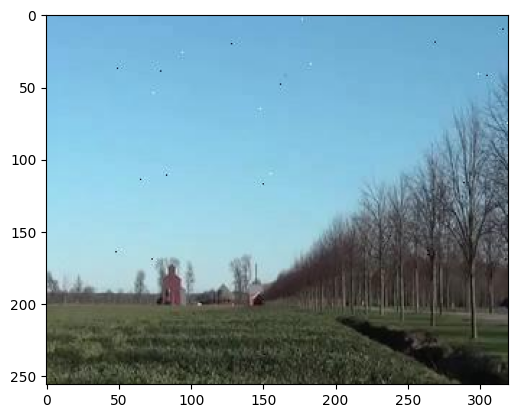

In [43]:
ir_images = sorted(os.listdir(ir_images_path))
ir_labels = sorted(os.listdir(ir_labels_path))
rgb_images = sorted(os.listdir(rgb_images_path))
rgb_labels = sorted(os.listdir(rgb_labels_path))

import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# Just take first image and label name directly------------------------------------------------\

sample_image_name = ir_images[0]
sample_image_name = rgb_images[1]
sample_label_name = ir_labels[0]
sample_label_name = rgb_labels[1]

# Full paths-------------------------------------------------------------------------\

sample_image_path = os.path.join(ir_images_path, sample_image_name) 
sample_label_path = os.path.join(ir_labels_path, sample_label_name)

sample_image_path = os.path.join(rgb_images_path, sample_image_name)
sample_label_path = os.path.join(rgb_labels_path, sample_label_name)

# Now read---------------------------------------------------------------------------\


image = cv2.imread(sample_image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Open the label file
with open(sample_label_path, 'r') as f:
    lines = f.readlines()

# Show--------------------------------------------------------------------------------\


plt.imshow(image_rgb)

# Open the label file
with open(sample_label_path, 'r') as f:
    lines = f.readlines()

# Now print each object info
for line in lines:
    parts = line.strip().split()
    if len(parts) != 5:
        continue  # skip if empty or malformed line
    class_id = int(parts[0])
    x_center = float(parts[1])
    y_center = float(parts[2])
    width = float(parts[3])
    height = float(parts[4])

    print(f"Class ID: {class_id}, Center: ({x_center}, {y_center}), Size: ({width}, {height})")



all_data = []

def process_images(images, labels, images_path, labels_path, mode='IR'):
    for image_name in tqdm(images):
        label_name = image_name.rsplit('.', 1)[0] + '.txt'
        image_path = os.path.join(images_path, image_name)
        label_path = os.path.join(labels_path, label_name)

        if not os.path.exists(label_path):
            continue  # Skip if label doesn't exist

        # Read label file
        with open(label_path, 'r') as f:
            lines = f.readlines()

        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            class_id = int(parts[0])
            x_center = float(parts[1])
            y_center = float(parts[2])
            width = float(parts[3])
            height = float(parts[4])

            # Collect into list
            all_data.append({
                'mode': mode,
                'image_name': image_name,
                'class_id': class_id,
                'x_center': x_center,
                'y_center': y_center,
                'width': width,
                'height': height
            })

# Run processing
process_images(ir_images, ir_labels, ir_images_path, ir_labels_path, mode='IR') # only ir images-----------------
# process_images(rgb_images, rgb_labels, rgb_images_path, rgb_labels_path, mode='RGB')

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Show basic info
print(df.head())
print(f"\nTotal entries: {len(df)}")

# Save to CSV if you want
df.to_csv('dataset_labels_summary.csv', index=False)

****# > # Split into train and val data****

In [4]:
import os
import random
import shutil
from glob import glob
from tqdm import tqdm

# Paths
image_dir = "/kaggle/input/ieee-vip-cup-dataset/dataset_vip_cup/IR/images"
label_dir = "/kaggle/input/ieee-vip-cup-dataset/dataset_vip_cup/IR/labels"

output_base = "/kaggle/working/split_dataset"
train_img_dir = os.path.join(output_base, "images/train")
val_img_dir = os.path.join(output_base, "images/val")
train_lbl_dir = os.path.join(output_base, "labels/train")
val_lbl_dir = os.path.join(output_base, "labels/val")

# Create output folders
for d in [train_img_dir, val_img_dir, train_lbl_dir, val_lbl_dir]:
    os.makedirs(d, exist_ok=True)

# Get all images
image_files = []
files = os.listdir(image_dir)  # Fast because it only lists names
for file in tqdm(files, desc="Scanning files..."):
    if file.lower().endswith(('.jpg', '.png')):
        image_files.append(os.path.join(image_dir, file))

# Shuffle
random.seed(42)
random.shuffle(image_files)

# Split
split_ratio = 0.8  # 80% train, 20% val
split_idx = int(len(image_files) * split_ratio)
train_files = image_files[:split_idx]
val_files = image_files[split_idx:]

# Helper function to copy images and labels
def copy_files(file_list, img_out_dir, lbl_out_dir):
    for img_path in tqdm(file_list):
        img_name = os.path.basename(img_path)
        lbl_name = os.path.splitext(img_name)[0] + ".txt"

        # Source paths
        src_lbl_path = os.path.join(label_dir, lbl_name)
        
        # Destination paths
        dst_img_path = os.path.join(img_out_dir, img_name)
        dst_lbl_path = os.path.join(lbl_out_dir, lbl_name)

        # Copy image
        shutil.copyfile(img_path, dst_img_path)

        # Copy label if exists
        if os.path.exists(src_lbl_path):
            shutil.copyfile(src_lbl_path, dst_lbl_path)

# Copy files
copy_files(train_files, train_img_dir, train_lbl_dir)
copy_files(val_files, val_img_dir, val_lbl_dir)

print(f"✅ Done! {len(train_files)} training images, {len(val_files)} validation images.")


100%|██████████| 11516/11516 [00:49<00:00, 234.22it/s]

✅ Done! 46064 training images, 11516 validation images.
